In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd

In [2]:
from data import load_dataset, build_target_df

dir = 'dataset_kids'

data, raw_annotations = load_dataset(dir)

In [3]:
def propogate_labels(annotations):
    return annotations.assign(flag_eyes=annotations[['flag_eyes', 'flag_eyes_h', 'flag_eyes_v']].any(axis=1),
                             flag_brain=annotations[['flag_brain', 'flag_alpha', 'flag_mu']].any(axis=1))

annotations = propogate_labels(raw_annotations)

In [4]:
from features import build_feature_df

features = build_feature_df(data)
features

,K,MEV,SAD,SVD,SED,MIF,CORR_BL,CORR_MOVE
IC000262,1.072924,7.849818,1.218625,0.312472,0.034570,0.048681,0.019231,0.008782
IC000263,-0.258669,2.826228,-0.098488,-0.017333,0.198680,0.194712,0.000708,0.000991
IC000264,-0.281039,2.405500,0.048190,-0.005600,0.195810,0.135989,0.000826,0.001222
IC000265,-0.109386,2.304496,-0.153483,-0.047035,0.102357,0.137081,0.001293,0.000845
IC000266,-0.184636,2.180311,-0.098674,-0.010143,0.185123,0.238028,0.000109,0.000302
...,...,...,...,...,...,...,...,...
IC000877,-0.146957,6.988684,0.042727,-0.004911,0.025780,0.121094,0.000665,0.001510
IC000878,-0.239456,3.270491,-0.024471,-0.000694,0.116370,0.088207,0.001756,0.001765
IC000879,-0.205477,4.605998,0.052680,0.000121,0.037387,0.114119,0.000769,0.000845
IC000880,-0.177250,3.021220,-0.042368,-0.000086,0.097905,0.117893,0.000812,0.001312


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay

def plot_roc_curve(ax, y_true, y_pred, title=None, lw=2, color='darkorange', **kwargs):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    
    ax.set_title(title)
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot(ax=ax, color=color, lw=lw, **kwargs)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

In [6]:
lr = LogisticRegression(solver='liblinear')

In [7]:
def repeated_train_test(features, target, model, n_repeats, test_size=0.3, ax=None, random_state=57):
    roc_aucs = []
    np.random.seed(random_state)
    for _ in range(n_repeats):
        try:
            X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=test_size)
            model.fit(X_train, y_train)
            y_pred = model.predict_proba(X_test)[:, 1]
            roc_aucs.append(roc_auc_score(y_test, y_pred))
            if ax is not None:
                plot_roc_curve(ax, y_test, y_pred, alpha=.1)
        except ValueError:
            continue
    if ax is not None:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel(flag)
        ax.set_ylabel('')
        ax.legend([f'average AUC = {np.mean(roc_aucs):.4f}'])

## Влияние разных стратегий построения таргета на обучение.

Консенсус экспертов.

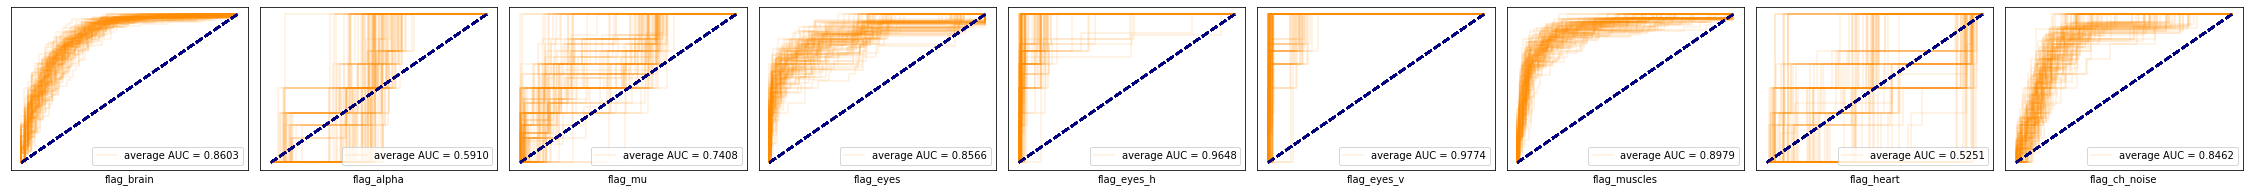

In [8]:
targets = build_target_df(annotations, strategy='all')
targets = targets.loc[:, targets.any(axis=0)]

fig, axes = plt.subplots(1, len(targets.columns), figsize=(40, 3))

for flag, ax in zip(targets.columns, axes):
    repeated_train_test(features, targets[flag], lr, 100, ax=ax)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

Хотя бы один эксперт.

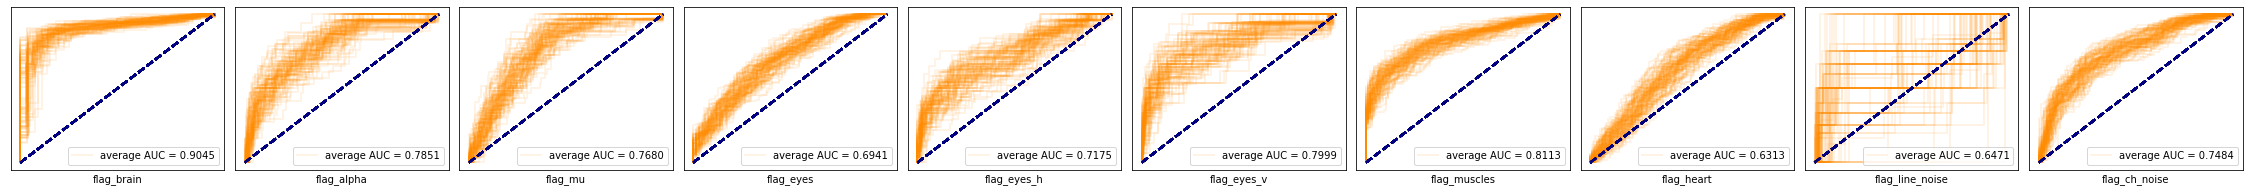

In [9]:
targets = build_target_df(annotations, strategy='any')
targets = targets.loc[:, targets.any(axis=0)]

fig, axes = plt.subplots(1, len(targets.columns), figsize=(40, 3))

for flag, ax in zip(targets.columns, axes):
    repeated_train_test(features, targets[flag], lr, 100, ax=ax)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

Голос эксперта равномерно делится между положительными метками.

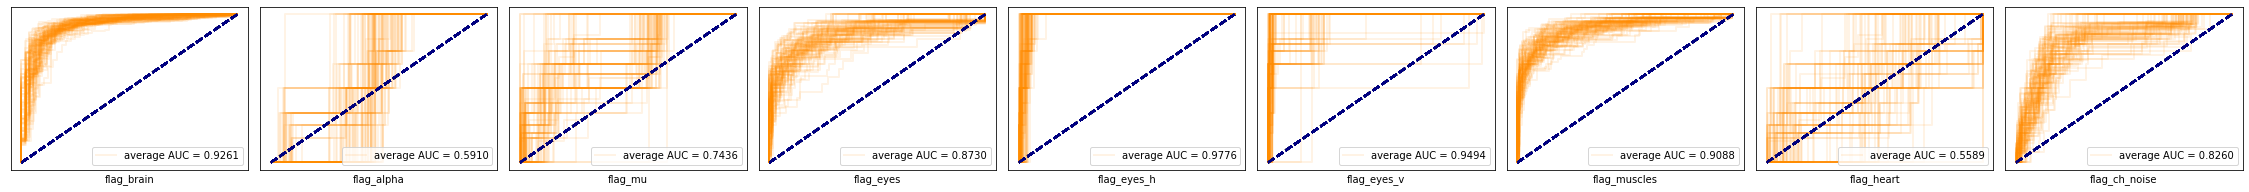

In [10]:
targets = build_target_df(annotations, strategy='mean', weights='uniform', threshold=.3)
targets = targets.loc[:, targets.any(axis=0)]

fig, axes = plt.subplots(1, len(targets.columns), figsize=(40, 3))

for flag, ax in zip(targets.columns, axes):
    repeated_train_test(features, targets[flag], lr, 100, ax=ax)
plt.subplots_adjust(wspace=0.05, hspace=0.05)